# Projeto com Marinha do Brasil

## Autor: Natanael Junior (natmourajr@gmail.com)

Laboratório de Processamento de Sinais - UFRJ

Laboratório de Tecnologia Sonar

Instituto de Pesquisas da Marinha - IPqM

# Bibliotecas
As bibliotecas necessárias para a inclusão

In [1]:
%time
import os
import pickle
import numpy as np
import time

from sklearn.externals import joblib

# path to data
inputpath = os.environ['INPUTDATAPATH']

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.15 µs


# Leitura dos dados
Leitura de dados de áudio

In [2]:
# function to convert int16 PCM to float
def wav_to_floats(data):
    a = [float(val) / pow(2, 15) for val in data]
    return a

In [88]:
import wave
import scipy.io.wavfile as wavefile

data_kind = 'RealData'#'RealData' # 'SimulatedData'
data = {}

if data_kind == 'RealData':
    file_names = ['m076.wav','m190.wav','m205.wav']
    for ifile, filename in enumerate(file_names):
        if(not os.path.exists(inputpath+'/'+data_kind+'/'+filename)):
            print 'File not exists'
            continue
        # this function read [fs,data]
        data[ifile] = wav_to_floats(wavefile.read(inputpath+'/'+data_kind+'/'+filename)[1])
        fs = wavefile.read(inputpath+'/'+data_kind+'/'+filename)[0]
elif data_kind == "SimulatedData":
    file_names = ['an0.wav','an1.wav']
    for ifile, filename in enumerate(file_names):
        if(not os.path.exists(inputpath+'/'+data_kind+'/'+filename)):
            print 'File not exists'
            continue
        # this function read [fs,data]
        data[ifile] = wav_to_floats(wavefile.read(inputpath+'/'+data_kind+'/'+filename)[1])
        fs = wavefile.read(inputpath+'/'+data_kind+'/'+filename)[0]


In [89]:
# Demon Analysis

import scipy.signal

data_abs = {}
data_decimate1 = {}
data_decimate2 = {}
data_demon = {}
data_demon_abs = {}

# demon parameters 
decimation_rate1 = 25
decimation_rate2= 25
n_pts_fft = 1024
window_size = 20 # in seconds
n_pts_windows = window_size*n_pts_fft
overlap = 0.5 # in seconds
n_pts_ovrlap = overlap*n_overlag_pts


for irecords in range(len(data)):
    data_abs[irecords] = np.abs(data[irecords])
    
    # decimation in 2 steps - first step
    data_decimate1[irecords] = scipy.signal.decimate(data_abs[irecords],
                                                   decimation_rate1,ftype='fir',n=10)
    fs_decimate1 = float(fs)/float(decimation_rate1)
    
    # decimation in 2 steps - second step
    data_decimate2[irecords] = scipy.signal.decimate(data_decimate1[irecords],
                                                    decimation_rate1,ftype='fir',n=10)
    fs_decimate2 = float(fs_decimate1)/float(decimation_rate2)
    
    f, t, Sxx = scipy.signal.spectrogram((data_decimate2[irecords].T
                                          -np.mean(data_decimate2[irecords])),
                                         fs=fs_decimate2,
                                         window=scipy.signal.hanning(n_pts_fft),
                                         nperseg=n_pts_fft,
                                         noverlap=0, nfft=n_pts_fft)
    data_demon[irecords] = Sxx
    data_demon_abs[irecords] = np.abs(data_demon[irecords])
    
    

In [81]:
# validar os resultados com a analise DEMON


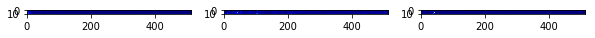

In [91]:
import matplotlib.pyplot as plt

%matplotlib inline


fig, ax= plt.subplots(figsize=(10,5),nrows=1, ncols=len(data_demon_abs))

for irecord in range(len(data_demon_abs)):
    ax[irecord].imshow(data_demon_abs[irecord].T,cmap="jet", aspect='equal')